## 使用RNN进行文本分类

**本教程使用RNN进行电影评论的分类，分为正向（赞美）和负向（批评）**  
评论数据如 `The movie was cool. The animation and the graphics` 为正向评论

###  第一步 导入需要的包

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

/home/tfuser/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tfuser/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tfuser/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tfuser/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dty


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



导入 `matplotlib` 并且创建一个用来画图的辅助函数

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## 第二步 读入数据，将文本数据转化为数值

所使用的数据为IMDB电影评论数据，每个评论被标注为正面评论或者消极评论

我们利用tensorflow提供的 [TFDS](https://www.tensorflow.org/datasets).进行数据的加载。


In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', data_dir='./tensorflow_datasets', with_info=True, download=False, 
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

数据集类中包含`info`属性中包含对文本编码器 (`tfds.features.text.SubwordTextEncoder`).  
如果使用其自带的编码器，需要自己手动构造词典，才能将文本转化为是实数值

In [4]:
encoder = info.features['text'].encoder

In [5]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


encoder能够将文字转为数字，也能将数字转为文字
This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [6]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('文字转数字 {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('数字再转回文字: "{}"'.format(original_string))

文字转数字 [4025, 222, 6307, 2327, 4043, 2120, 7975]
数字再转回文字: "Hello TensorFlow."


打印文字和数字的对应关系

In [7]:
for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### 第三步 准备训练数据，将寻来呢数据切分成batch

利用encoder创建寻来呢数据. 使用 `padded_batch` 函数把同一个batch里的数据补到相同的长度

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

### 第四步 创建模型

使用 `tf.keras.Sequential` 创建模型（可以理解为一个深度网络的容器）包含以下各个层    
- **embedding层** 将词的id转为一个向量，每个词对应一个向量，经过训练以后，相同的词其对应向量相同.

- **双向LSTM** LSTM网络读入每个词的向量，进行组合表示，经过RNN输出的每个的词表示包含了其上下文的信息

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

设置模型的损失函数和评价指标

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### 第五步 训练模型

**注意** 考虑到大家个人电脑一般性能比较差，我们把训练数据步数`steps_per_epoch`调的比较小。
大家如果真正用的时候需要调大到`steps_per_epoch=1000`左右，训练的时间更久才能达到比较好的泛化性能。

In [15]:

history = model.fit(train_dataset, epochs=3,
                    validation_data=test_dataset, 
                    validation_steps=30, steps_per_epoch=10)

Epoch 1/3
10/10 [==============================] - 70s 7s/step - loss: 0.6928 - acc: 0.5172 - val_loss: 0.6937 - val_acc: 0.4896
Epoch 2/3
10/10 [==============================] - 67s 7s/step - loss: 0.6936 - acc: 0.4891 - val_loss: 0.6936 - val_acc: 0.4974
Epoch 3/3
10/10 [==============================] - 79s 8s/step - loss: 0.6940 - acc: 0.4844 - val_loss: 0.6937 - val_acc: 0.4844


In [24]:
test_loss, test_acc = model.evaluate(test_dataset, steps=10)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

10/10 [==============================] - 6s 617ms/step - loss: 0.6929 - acc: 0.4984
Test Loss: 0.6928939700126648
Test Accuracy: 0.4984374940395355


### 第六步 在单条样本上进行测试

In [25]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [33]:
# 对文本转换为数字id，再输入模型进行预测
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0), steps=1)

  return (predictions)

In [34]:
# 预测
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.49324664]]


### 绘制准确率和损失随着训练epoch的变化

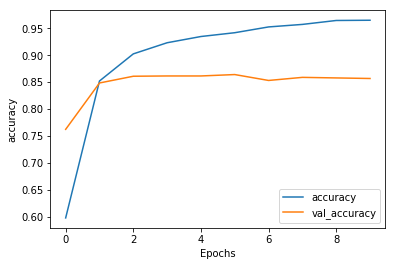

In [20]:
plot_graphs(history, 'accuracy')

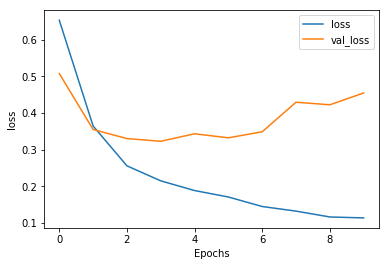

In [21]:
plot_graphs(history, 'loss')